# Lotto 5/35 Basic

In [1]:
import time
from datetime import datetime
from typing import List, Optional, Tuple
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
from scipy.stats import norm

from selenium import webdriver
from selenium.webdriver.chromium.webdriver import ChromiumDriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait, Select
from selenium.webdriver.support import expected_conditions as EC

from bs4 import BeautifulSoup, Tag

## Parameters

## Import libraries

In [2]:
URL = "https://www.minhchinh.com/thong-ke-lotto-535.html"
FROM_DATE = "01-01-2024"  # dd-MM-yyyy
TO_DATE = datetime.now().strftime("%d-%m-%Y")  # dd-MM-yyyy
FROM_DATE, TO_DATE

('01-01-2024', '21-02-2026')

In [3]:
LOTTO_5_35_FILE_NAME = "lotto_5_35"
LOTTO_5_35_CLEANED_FILE_NAME = "lotto_5_35_cleaned"

In [4]:
SCRAPER_BASE_WAIT_TIME = 1

## Helper functions

In [5]:
def update_bs4_parser(web_driver: ChromiumDriver) -> BeautifulSoup:
    return BeautifulSoup(web_driver.page_source, "html.parser")

In [6]:
def navigate_to_url(
    web_driver: ChromiumDriver, url: str
) -> Tuple[ChromiumDriver, BeautifulSoup]:
    print(f'Navigating to URL: "{url}"')
    web_driver.get(url)
    time.sleep(SCRAPER_BASE_WAIT_TIME)
    bs4_parser = update_bs4_parser(web_driver)

    return (web_driver, bs4_parser)

In [7]:
def input_text(web_driver: ChromiumDriver, xpath: str, value: str) -> None:
    input_element = WebDriverWait(web_driver, 10).until(
        EC.element_to_be_clickable((By.XPATH, xpath))
    )
    input_element.clear()
    input_element.send_keys(value)

In [8]:
def click_element(web_driver: ChromiumDriver, xpath: str) -> None:
    element = WebDriverWait(web_driver, 10).until(
        EC.element_to_be_clickable((By.XPATH, xpath))
    )
    element.click()

In [9]:
def extract_table(table: Optional[Tag]):
    # Extract headers
    headers = []
    thead = table.find("thead")
    if thead:
        header_row = thead.find_all("tr")[-1]  # use the last row if rowspan is present
        headers = [th.get_text(strip=True) for th in header_row.find_all("th")]

    # Extract rows
    rows = []
    tbody = table.find("tbody")
    for tr in tbody.find_all("tr"):
        # Skip group title rows
        if tr.get("class") and "group" in tr.get("class"):
            continue
        row = []
        for td in tr.find_all(["td"]):
            text = td.get_text(strip=True)
            row.append(text)
        rows.append(row)

    return (headers, rows)


def extract_table_by_class(
    bs4_parser: BeautifulSoup, class_name: str
) -> Tuple[List, List]:
    table = bs4_parser.find("table", class_=class_name)
    return extract_table(table)

## Start

### Scrape data from web

In [10]:
chrome_options = Options()
chrome_options.add_experimental_option(
    "prefs",
    {
        "profile.managed_default_content_settings.images": 2,  # Disable images
        "profile.managed_default_content_settings.stylesheets": 2,  # Disable CSS
        "profile.managed_default_content_settings.javascript": 1,  # Keep JS if needed
    },
)
chrome_options.add_argument(
    "user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36"
)

In [11]:
web_driver: ChromiumDriver = webdriver.Chrome(options=chrome_options)
bs4_parser: BeautifulSoup = BeautifulSoup(web_driver.page_source, "html.parser")
web_driver.maximize_window()

In [12]:
navigate_to_url(web_driver, URL)

from_date_xpath = '//*[@id="dateFromId"]'
to_date_xpath = '//*[@id="dateToId"]'
submit_button_xpath = '//*[@id="noidung"]/div[2]/div/div[1]/div/button'

click_element(web_driver, from_date_xpath)
input_text(web_driver, from_date_xpath, FROM_DATE)

click_element(web_driver, to_date_xpath)
input_text(web_driver, to_date_xpath, TO_DATE)

click_element(web_driver, submit_button_xpath)

time.sleep(SCRAPER_BASE_WAIT_TIME * 2)

bs4_parser = update_bs4_parser(web_driver)

Navigating to URL: "https://www.minhchinh.com/thong-ke-lotto-535.html"


In [13]:
table_class_name = "table-mini-result"

raw_table = extract_table_by_class(bs4_parser, table_class_name)

if len(raw_table):
    with open(
        f"{LOTTO_5_35_FILE_NAME}.csv", "w", newline="\n", encoding="utf-8"
    ) as file:
        writer = csv.writer(file)
        writer.writerows([raw_table[0]])
        writer.writerows(raw_table[1])

print(f"Data has been saved to '{LOTTO_5_35_FILE_NAME}.csv'")

web_driver.close()

Data has been saved to 'lotto_5_35.csv'


### Preprocess data

In [14]:
pandas_df = pd.read_csv(f"{LOTTO_5_35_FILE_NAME}.csv", dtype=str)

# Extract date and hour
pandas_df["date"] = pandas_df["NgàyMở Thưởng"].str.split().str[0]
pandas_df["hour"] = (
    pandas_df["NgàyMở Thưởng"].str.split().str[1].str.replace("h", "", regex=False)
)

# Split 12-digit result into 6 two-digit numbers
for i in range(6):
    col_name = f"x_{i+1}" if i < 5 else "x_s"
    pandas_df[col_name] = pandas_df["Kết Quả"].str[i * 2 : (i + 1) * 2]

# Clean prize (remove commas)
pandas_df["prize"] = pandas_df["Độc Đắc"].str.replace(",", "", regex=False)

# Keep only new columns
pandas_df = pandas_df[
    ["date", "hour", "x_1", "x_2", "x_3", "x_4", "x_5", "x_s", "prize"]
]

pandas_df

,date,hour,x_1,x_2,x_3,x_4,x_5,x_s,prize
0,20/02/26,21,01,09,18,28,33,07,6854822500
1,20/02/26,13,10,12,27,30,31,12,6727910000
2,19/02/26,21,09,21,23,25,29,03,6569592500
3,19/02/26,13,01,13,14,19,30,01,6438642500
4,18/02/26,21,09,23,27,29,33,01,6248570000
...,...,...,...,...,...,...,...,...,...
469,01/07/25,13,01,18,25,27,33,05,6676525000
470,30/06/25,21,01,12,13,27,28,07,6518352500
471,30/06/25,13,02,08,16,23,24,09,6315905000
472,29/06/25,21,06,12,14,18,25,08,6231295000


In [15]:
pandas_df.to_csv(f"{LOTTO_5_35_CLEANED_FILE_NAME}.csv", index=False)

### Read data

In [16]:
cleaned_df = pd.read_csv(f"{LOTTO_5_35_CLEANED_FILE_NAME}.csv")
cleaned_df

,date,hour,x_1,x_2,x_3,x_4,x_5,x_s,prize
0,20/02/26,21,1,9,18,28,33,7,6854822500
1,20/02/26,13,10,12,27,30,31,12,6727910000
2,19/02/26,21,9,21,23,25,29,3,6569592500
3,19/02/26,13,1,13,14,19,30,1,6438642500
4,18/02/26,21,9,23,27,29,33,1,6248570000
...,...,...,...,...,...,...,...,...,...
469,01/07/25,13,1,18,25,27,33,5,6676525000
470,30/06/25,21,1,12,13,27,28,7,6518352500
471,30/06/25,13,2,8,16,23,24,9,6315905000
472,29/06/25,21,6,12,14,18,25,8,6231295000


### Setting

In [17]:
SETTINGS = {
    "x_1": {"n_highest": 5, "n_outlier": True},
    "x_2": {"n_highest": 5, "n_outlier": True},
    "x_3": {"n_highest": 5, "n_outlier": True},
    "x_4": {"n_highest": 5, "n_outlier": True},
    "x_5": {"n_highest": 5, "n_outlier": True},
    "x_s": {"n_highest": 5, "n_outlier": True},
}

### Analysis data

In [18]:
def make_centered_bins(min_value, n_bins, column_width):
    start = min_value - column_width / 2
    end = min_value + n_bins - 1 + column_width / 2
    return np.arange(start, end + column_width, column_width)


def plot_histograms(cleaned_df, column_width=0.5, mode="percentage"):
    """
    Plots histograms for predefined columns in cleaned_df.

    Parameters:
    - cleaned_df (pd.DataFrame): DataFrame containing the data
    - column_width (float): Width of histogram bins
    - mode (str): "percentage" or "count"
    """

    if mode not in ["percentage", "count"]:
        raise ValueError("mode must be 'percentage' or 'count'")

    columns = ["x_1", "x_2", "x_3", "x_4", "x_5", "x_s"]

    fig, axes = plt.subplots(3, 2, figsize=(30, 15), sharex=False)
    axes = axes.flatten()

    for i, col in enumerate(columns):

        if col not in cleaned_df.columns:
            raise ValueError(f"Column '{col}' not found in DataFrame")

        data = cleaned_df[col].astype(int)

        # Choose bin range
        if col == "x_s":
            bins = make_centered_bins(1, 12, column_width)
            xticks = range(1, 13)
        else:
            bins = make_centered_bins(1, 35, column_width)
            xticks = range(1, 36)

        # Apply weights only if percentage mode
        if mode == "percentage":
            weights = np.ones_like(data) * 100.0 / len(data)
            axes[i].hist(data, bins=bins, weights=weights)
            axes[i].set_ylabel("Percentage (%)")
        else:
            axes[i].hist(data, bins=bins)
            axes[i].set_ylabel("Count")

        axes[i].set_xticks(xticks)
        axes[i].set_title(col)
        axes[i].tick_params(axis="x", bottom=True, labelbottom=True)

    plt.tight_layout()
    plt.show()


def extended_summary(series):
    summary = {
        "Count": series.count(),
        "Mean": series.mean(),
        "Median": series.median(),
        "Mode": series.mode().iloc[0] if not series.mode().empty else None,
        "Std Dev": series.std(),
        "Variance": series.var(),
        "Min": series.min(),
        "Max": series.max(),
        "Skewness": series.skew(),
        "Kurtosis": series.kurt(),
        "Unique Values": series.nunique(),
    }

    return pd.DataFrame(summary, index=[series.name]).T

In [19]:
# Plot config
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (14, 6)
column_width = 0.5

In [20]:
cleaned_df

,date,hour,x_1,x_2,x_3,x_4,x_5,x_s,prize
0,20/02/26,21,1,9,18,28,33,7,6854822500
1,20/02/26,13,10,12,27,30,31,12,6727910000
2,19/02/26,21,9,21,23,25,29,3,6569592500
3,19/02/26,13,1,13,14,19,30,1,6438642500
4,18/02/26,21,9,23,27,29,33,1,6248570000
...,...,...,...,...,...,...,...,...,...
469,01/07/25,13,1,18,25,27,33,5,6676525000
470,30/06/25,21,1,12,13,27,28,7,6518352500
471,30/06/25,13,2,8,16,23,24,9,6315905000
472,29/06/25,21,6,12,14,18,25,8,6231295000


### Plot charts

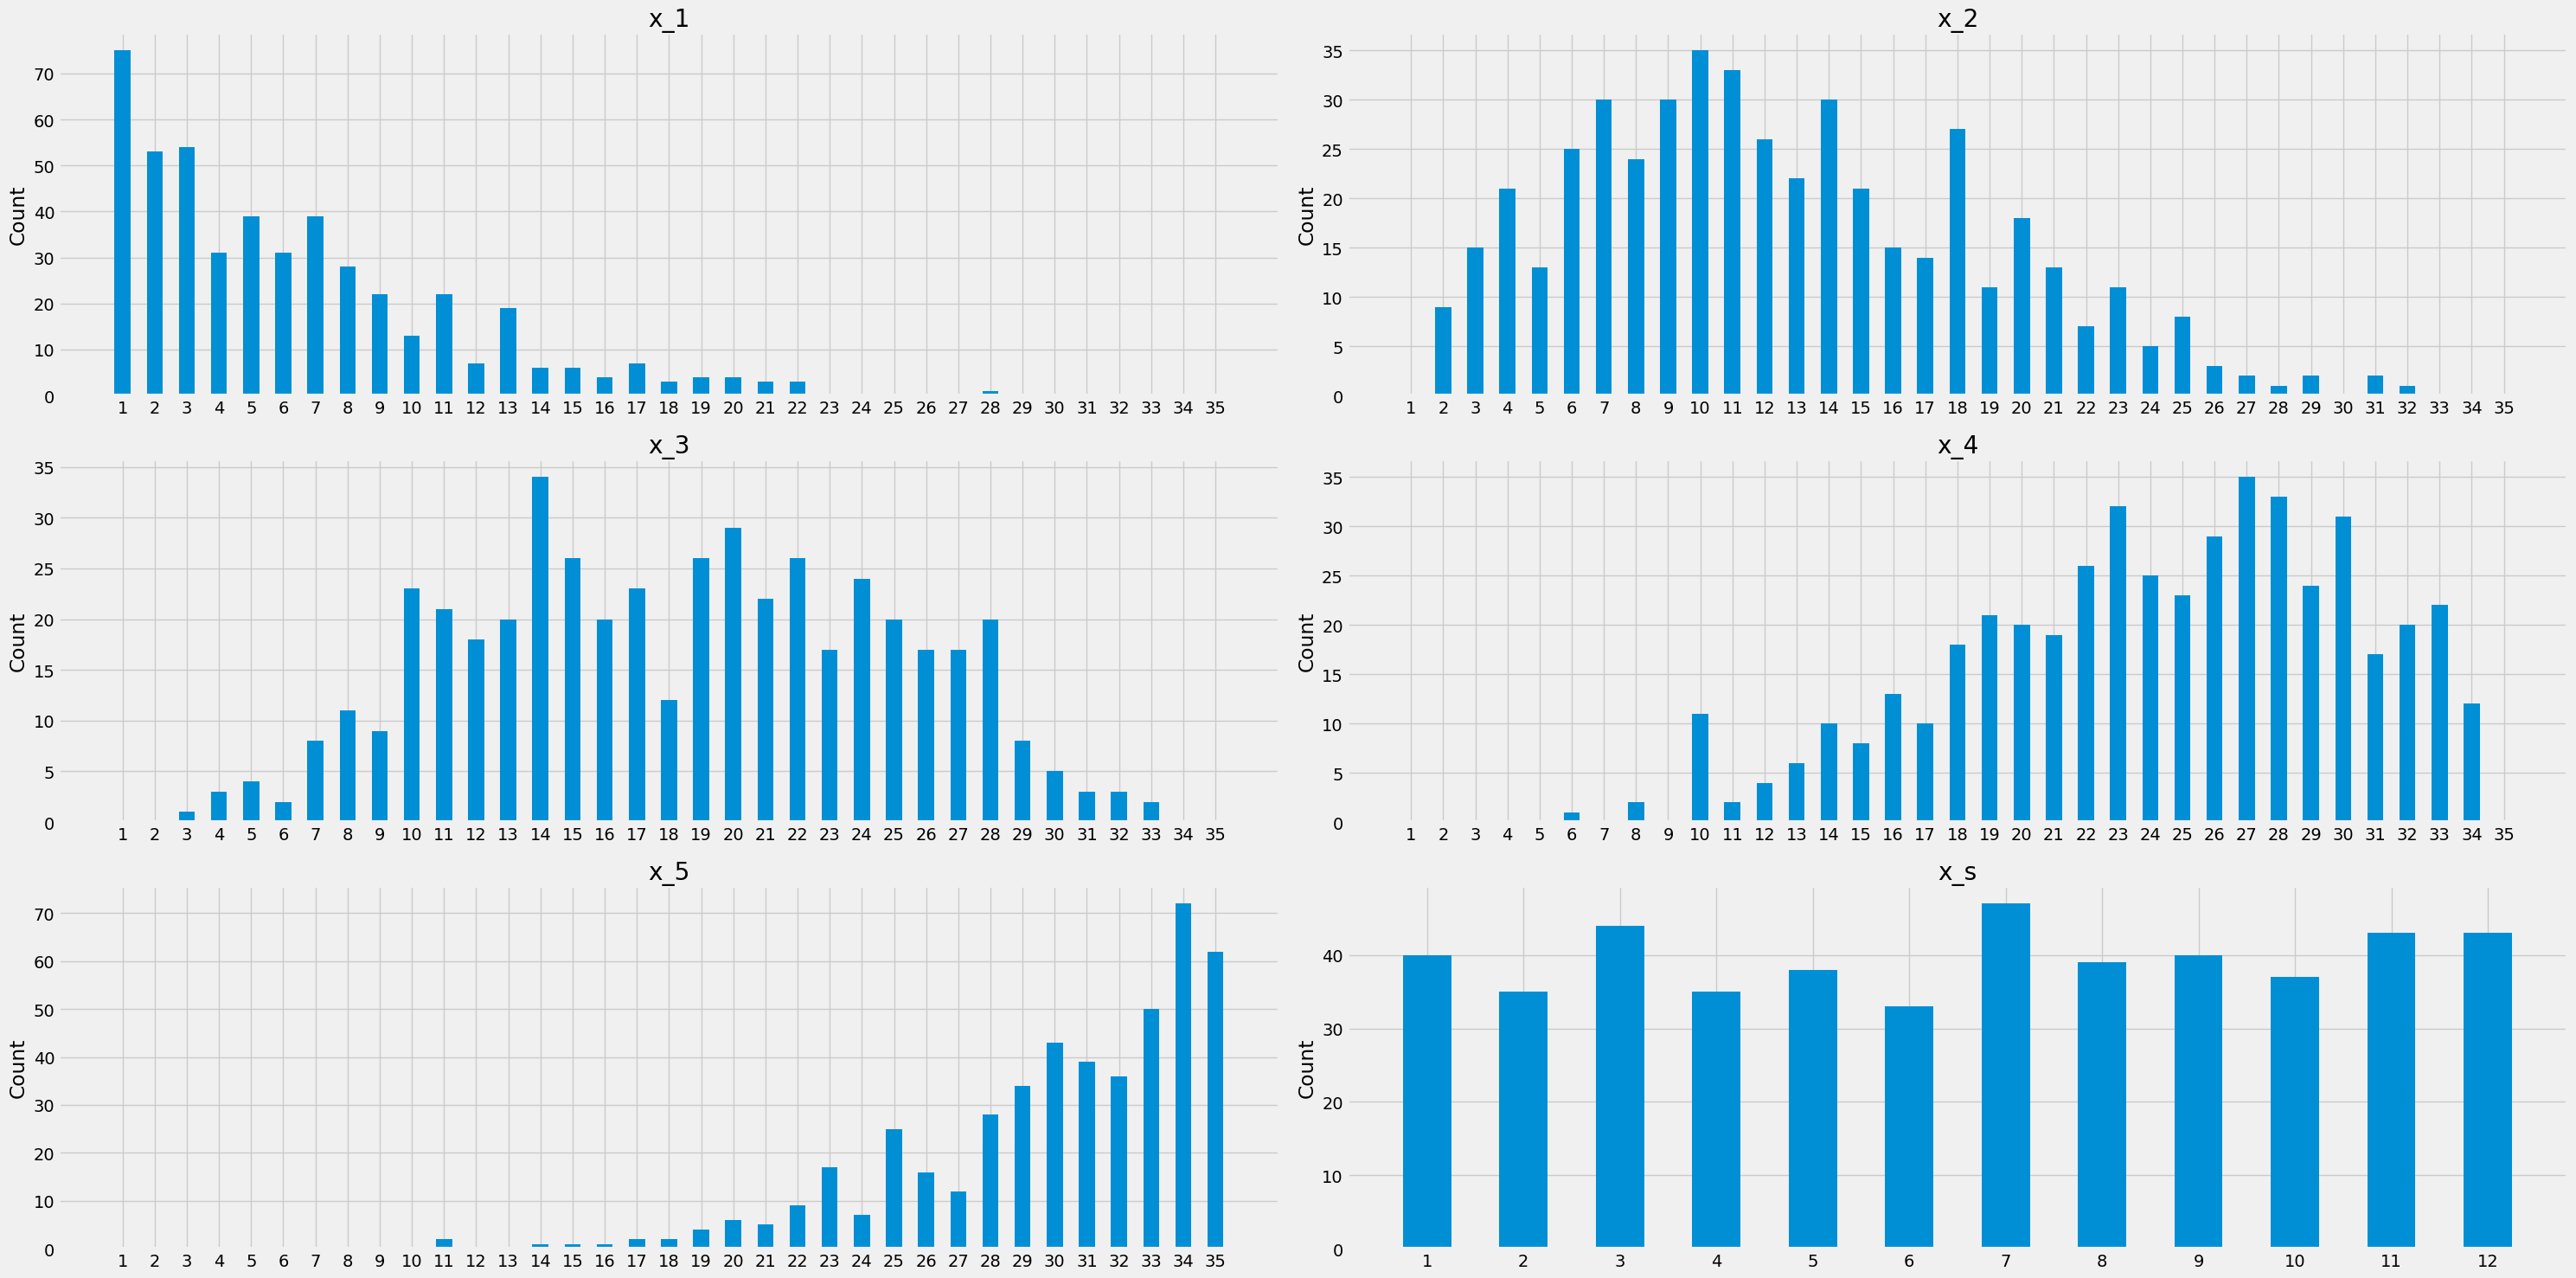

In [21]:
plot_histograms(cleaned_df, mode="count")

In [22]:
extended_summary(cleaned_df["x_1"])

,x_1
Count,474.000000
Mean,6.265823
Median,5.000000
Mode,1.000000
Std Dev,4.944621
Variance,24.449273
Min,1.000000
Max,28.000000
Skewness,1.185385
Kurtosis,1.214708


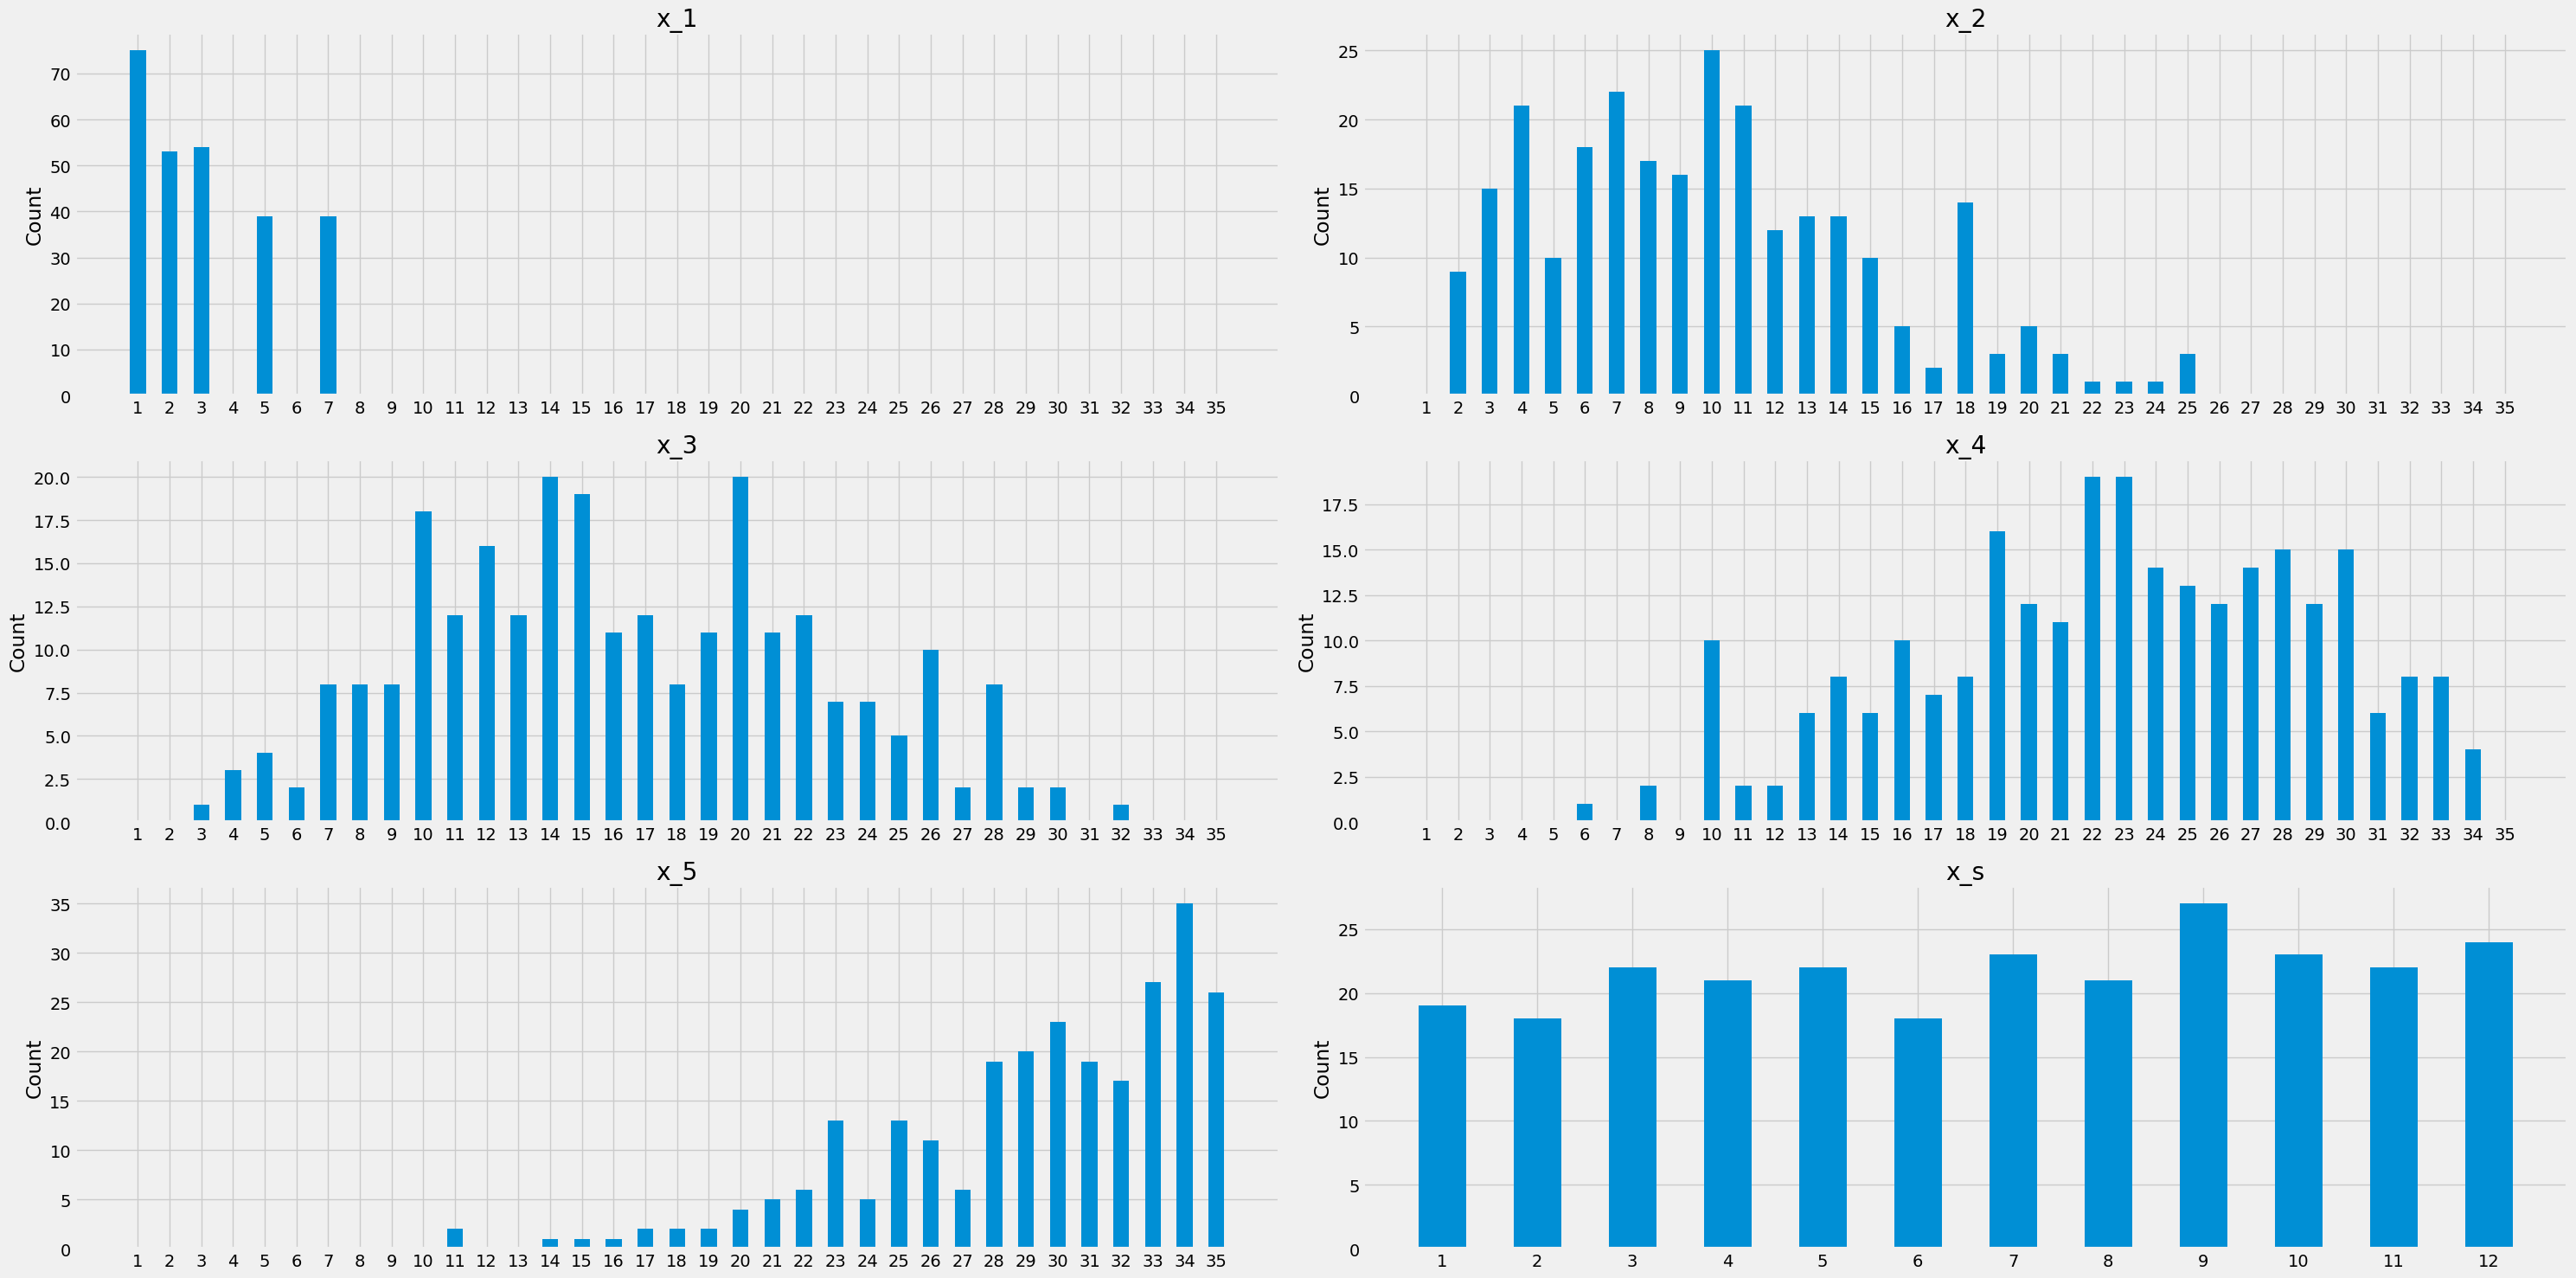

In [44]:
filter_1 = cleaned_df[cleaned_df["x_1"].isin([1, 2, 3, 5, 7])]

plot_histograms(filter_1, mode="count")

In [24]:
extended_summary(filter_1["x_2"])

,x_2
Count,329.000000
Mean,11.267477
Median,11.000000
Mode,10.000000
Std Dev,5.684398
Variance,32.312384
Min,2.000000
Max,31.000000
Skewness,0.497618
Kurtosis,-0.141202


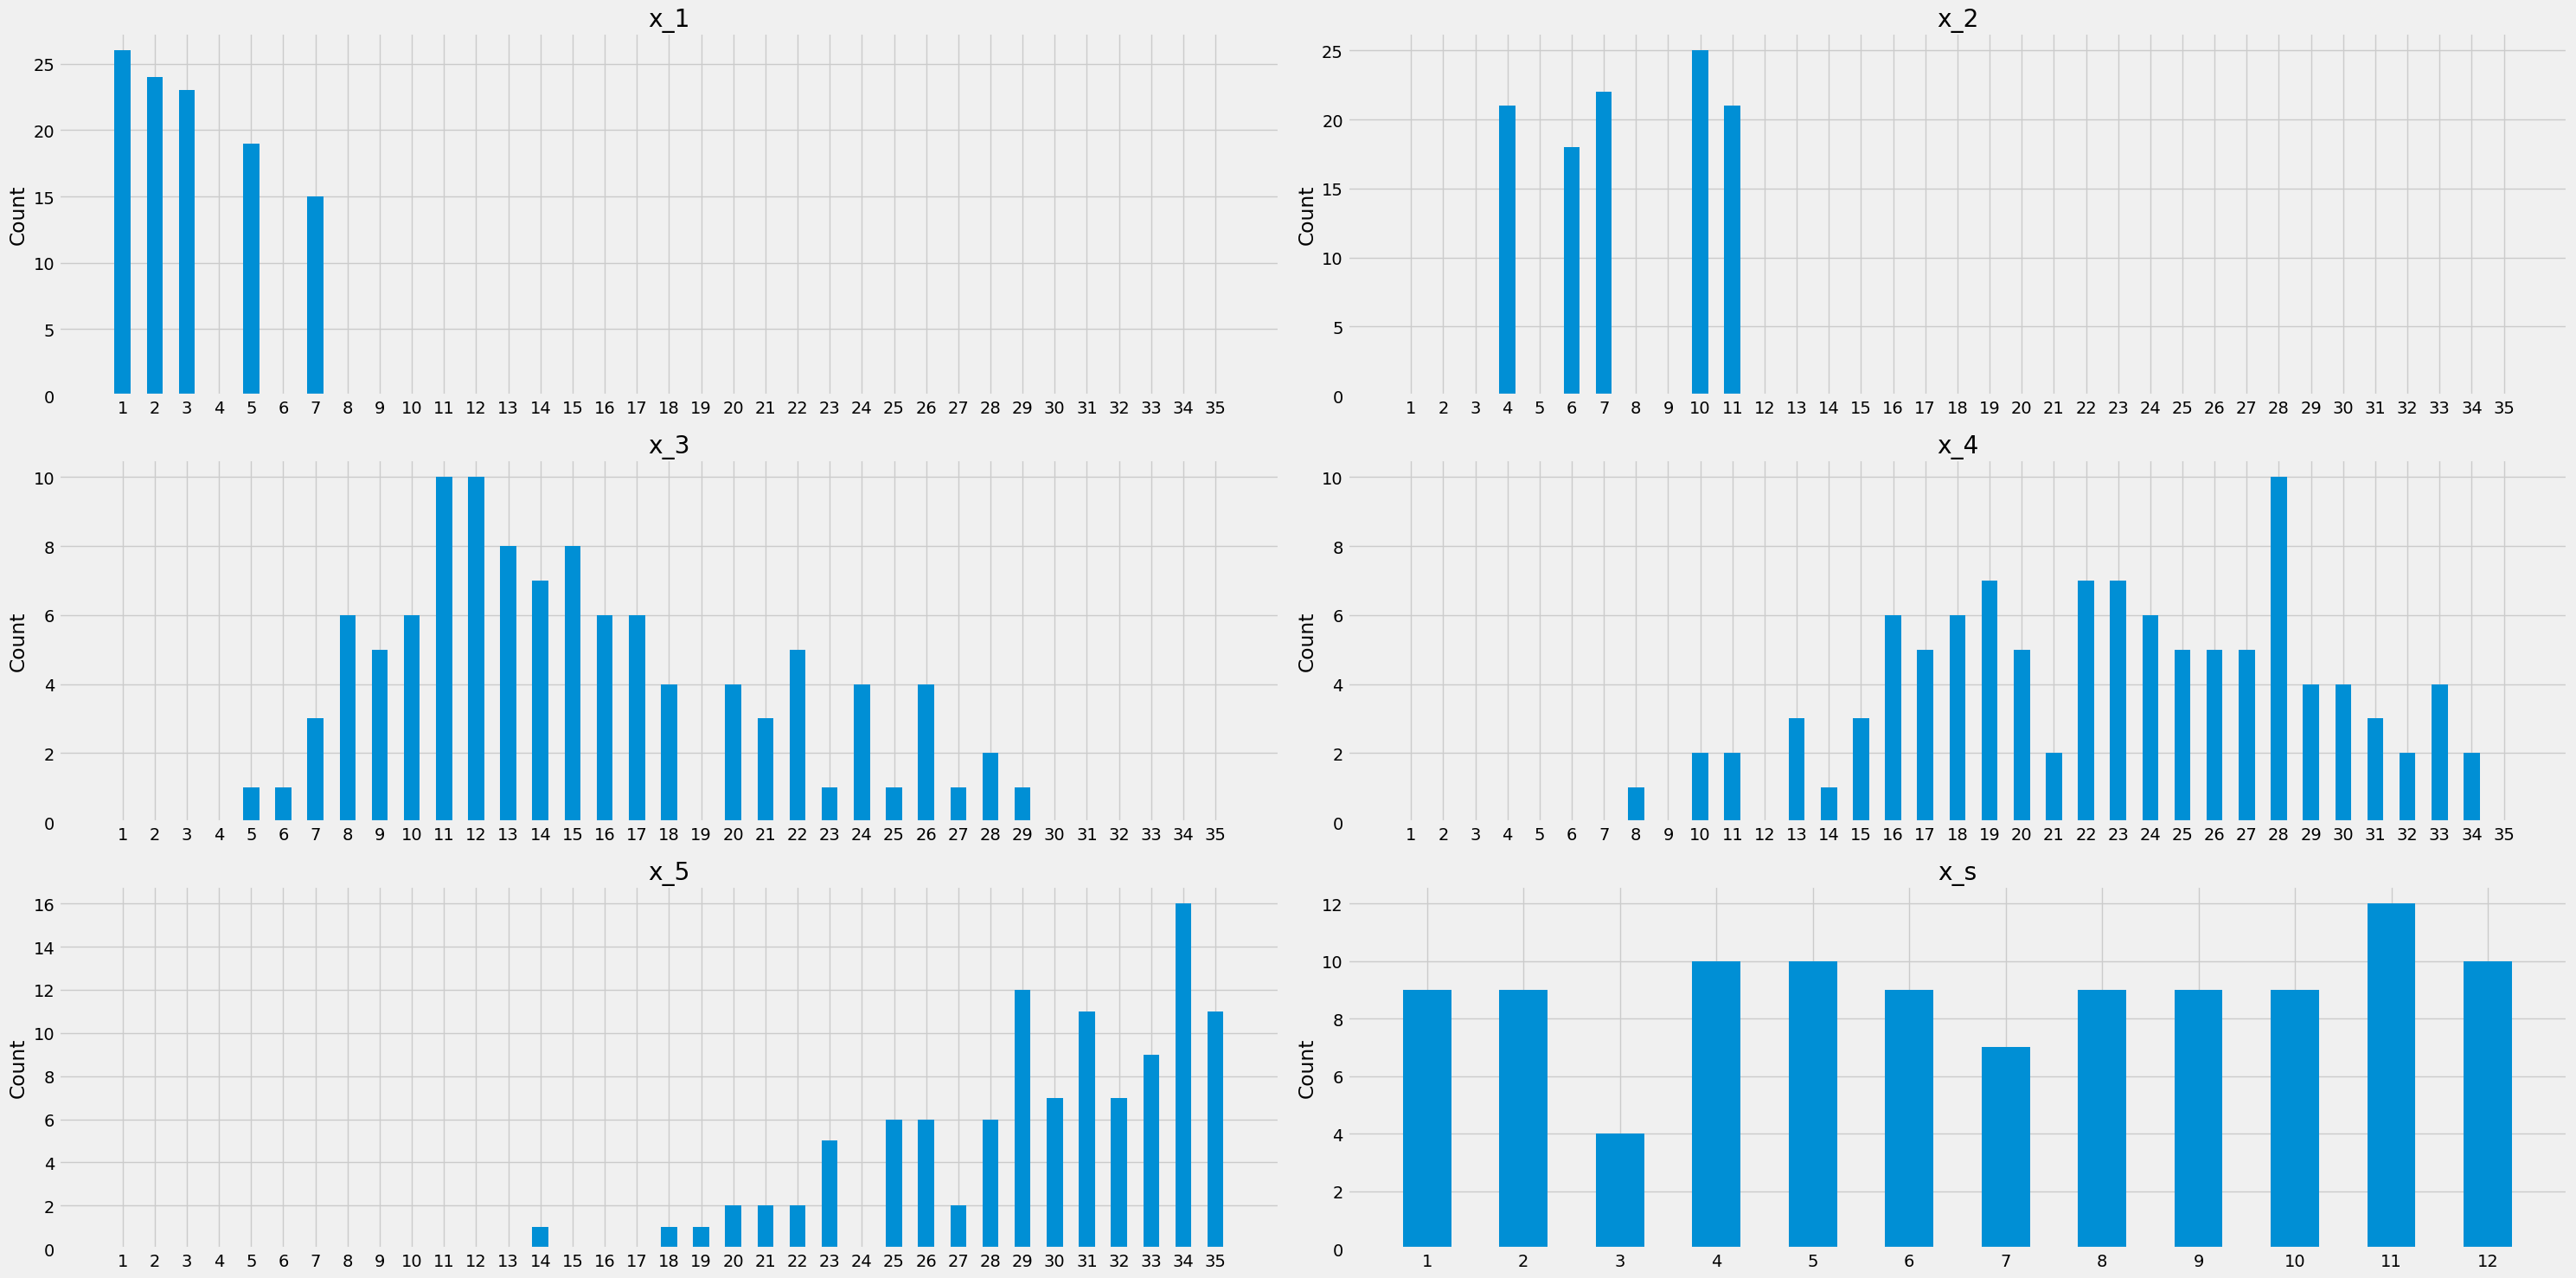

In [45]:
filter_2 = cleaned_df[
    cleaned_df["x_1"].isin([1, 2, 3, 5, 7]) & cleaned_df["x_2"].isin([4, 6, 7, 10, 11])
]

plot_histograms(filter_2, mode="count")

In [26]:
extended_summary(filter_2["x_3"])

,x_3
Count,182.000000
Mean,16.565934
Median,16.000000
Mode,15.000000
Std Dev,5.850206
Variance,34.224910
Min,4.000000
Max,32.000000
Skewness,0.179415
Kurtosis,-0.652751


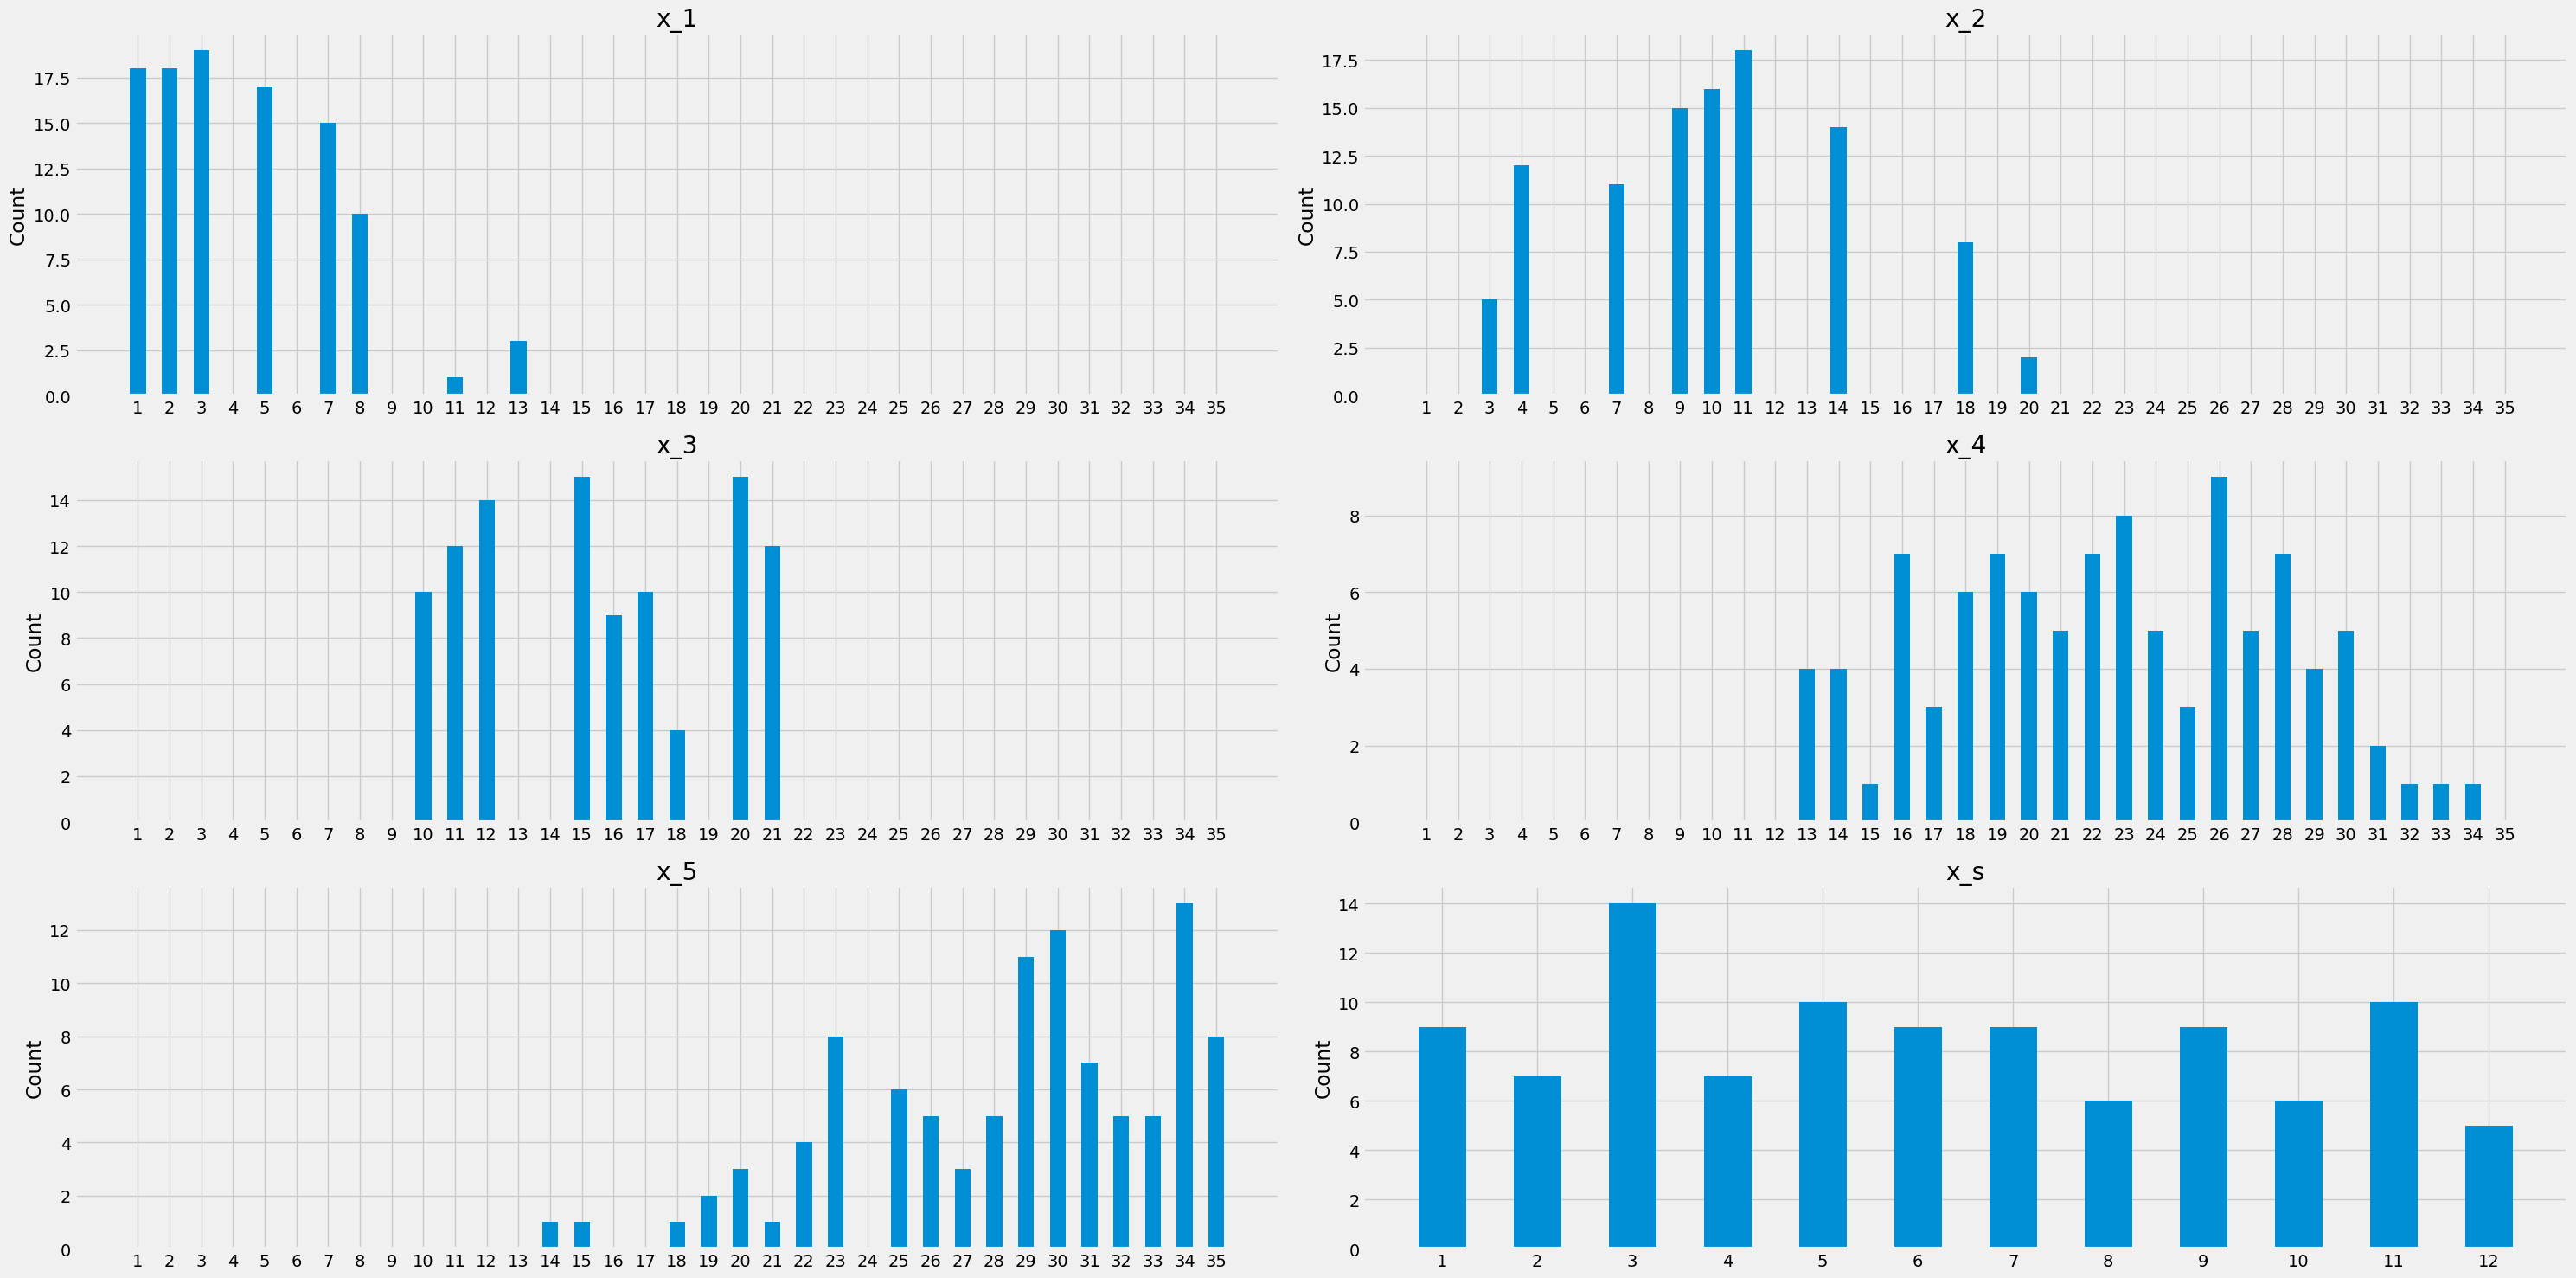

In [27]:
filter_3 = cleaned_df[
    cleaned_df["x_1"].isin([1, 2, 3, 5, 7, 8, 11, 13])
    & cleaned_df["x_2"].isin([3, 4, 7, 9, 10, 11, 14, 18, 20])
    & cleaned_df["x_3"].isin([16, 17, 18, 10, 11, 12, 15, 20, 21])
]

plot_histograms(filter_3, mode="count")

In [28]:
extended_summary(filter_3["x_4"])

,x_4
Count,101.000000
Mean,22.544554
Median,23.000000
Mode,26.000000
Std Dev,5.227858
Variance,27.330495
Min,13.000000
Max,34.000000
Skewness,-0.000728
Kurtosis,-0.863913


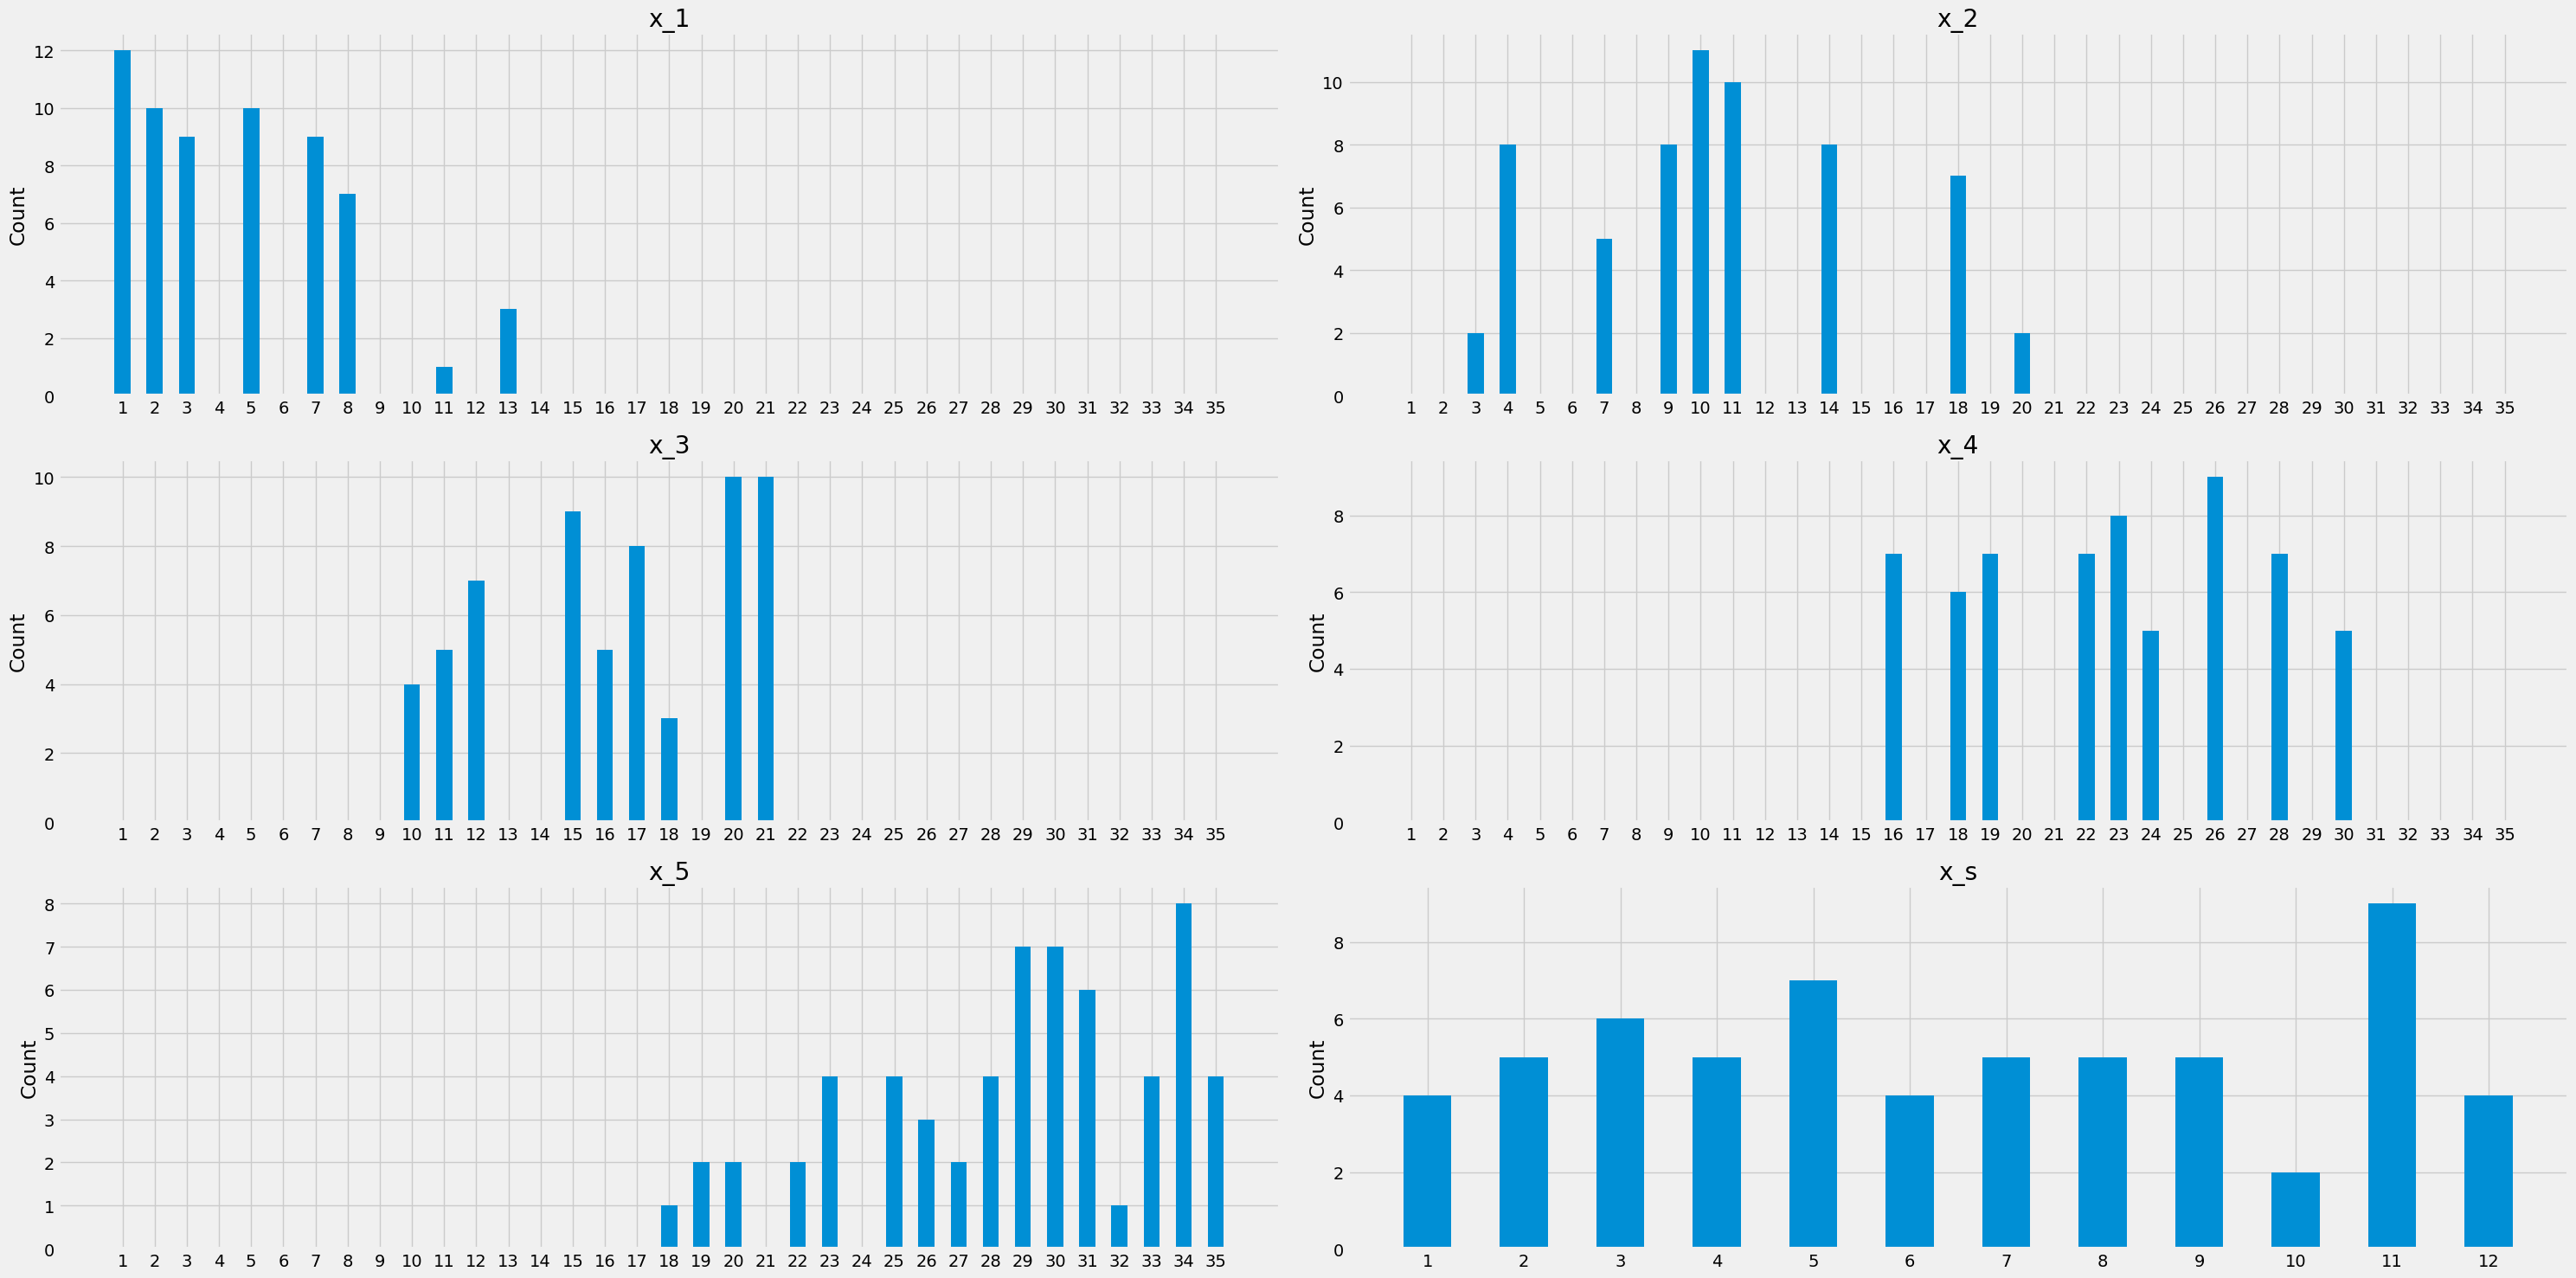

In [29]:
filter_4 = cleaned_df[
    cleaned_df["x_1"].isin([1, 2, 3, 5, 7, 8, 11, 13])
    & cleaned_df["x_2"].isin([3, 4, 7, 9, 10, 11, 14, 18, 20])
    & cleaned_df["x_3"].isin([16, 17, 18, 10, 11, 12, 15, 20, 21])
    & cleaned_df["x_4"].isin([22, 23, 24, 16, 19, 18, 26, 28, 30])
]

plot_histograms(filter_4, mode="count")

In [30]:
extended_summary(filter_4["x_5"])

,x_5
Count,61.000000
Mean,28.704918
Median,29.000000
Mode,34.000000
Std Dev,4.601972
Variance,21.178142
Min,18.000000
Max,35.000000
Skewness,-0.595402
Kurtosis,-0.453507


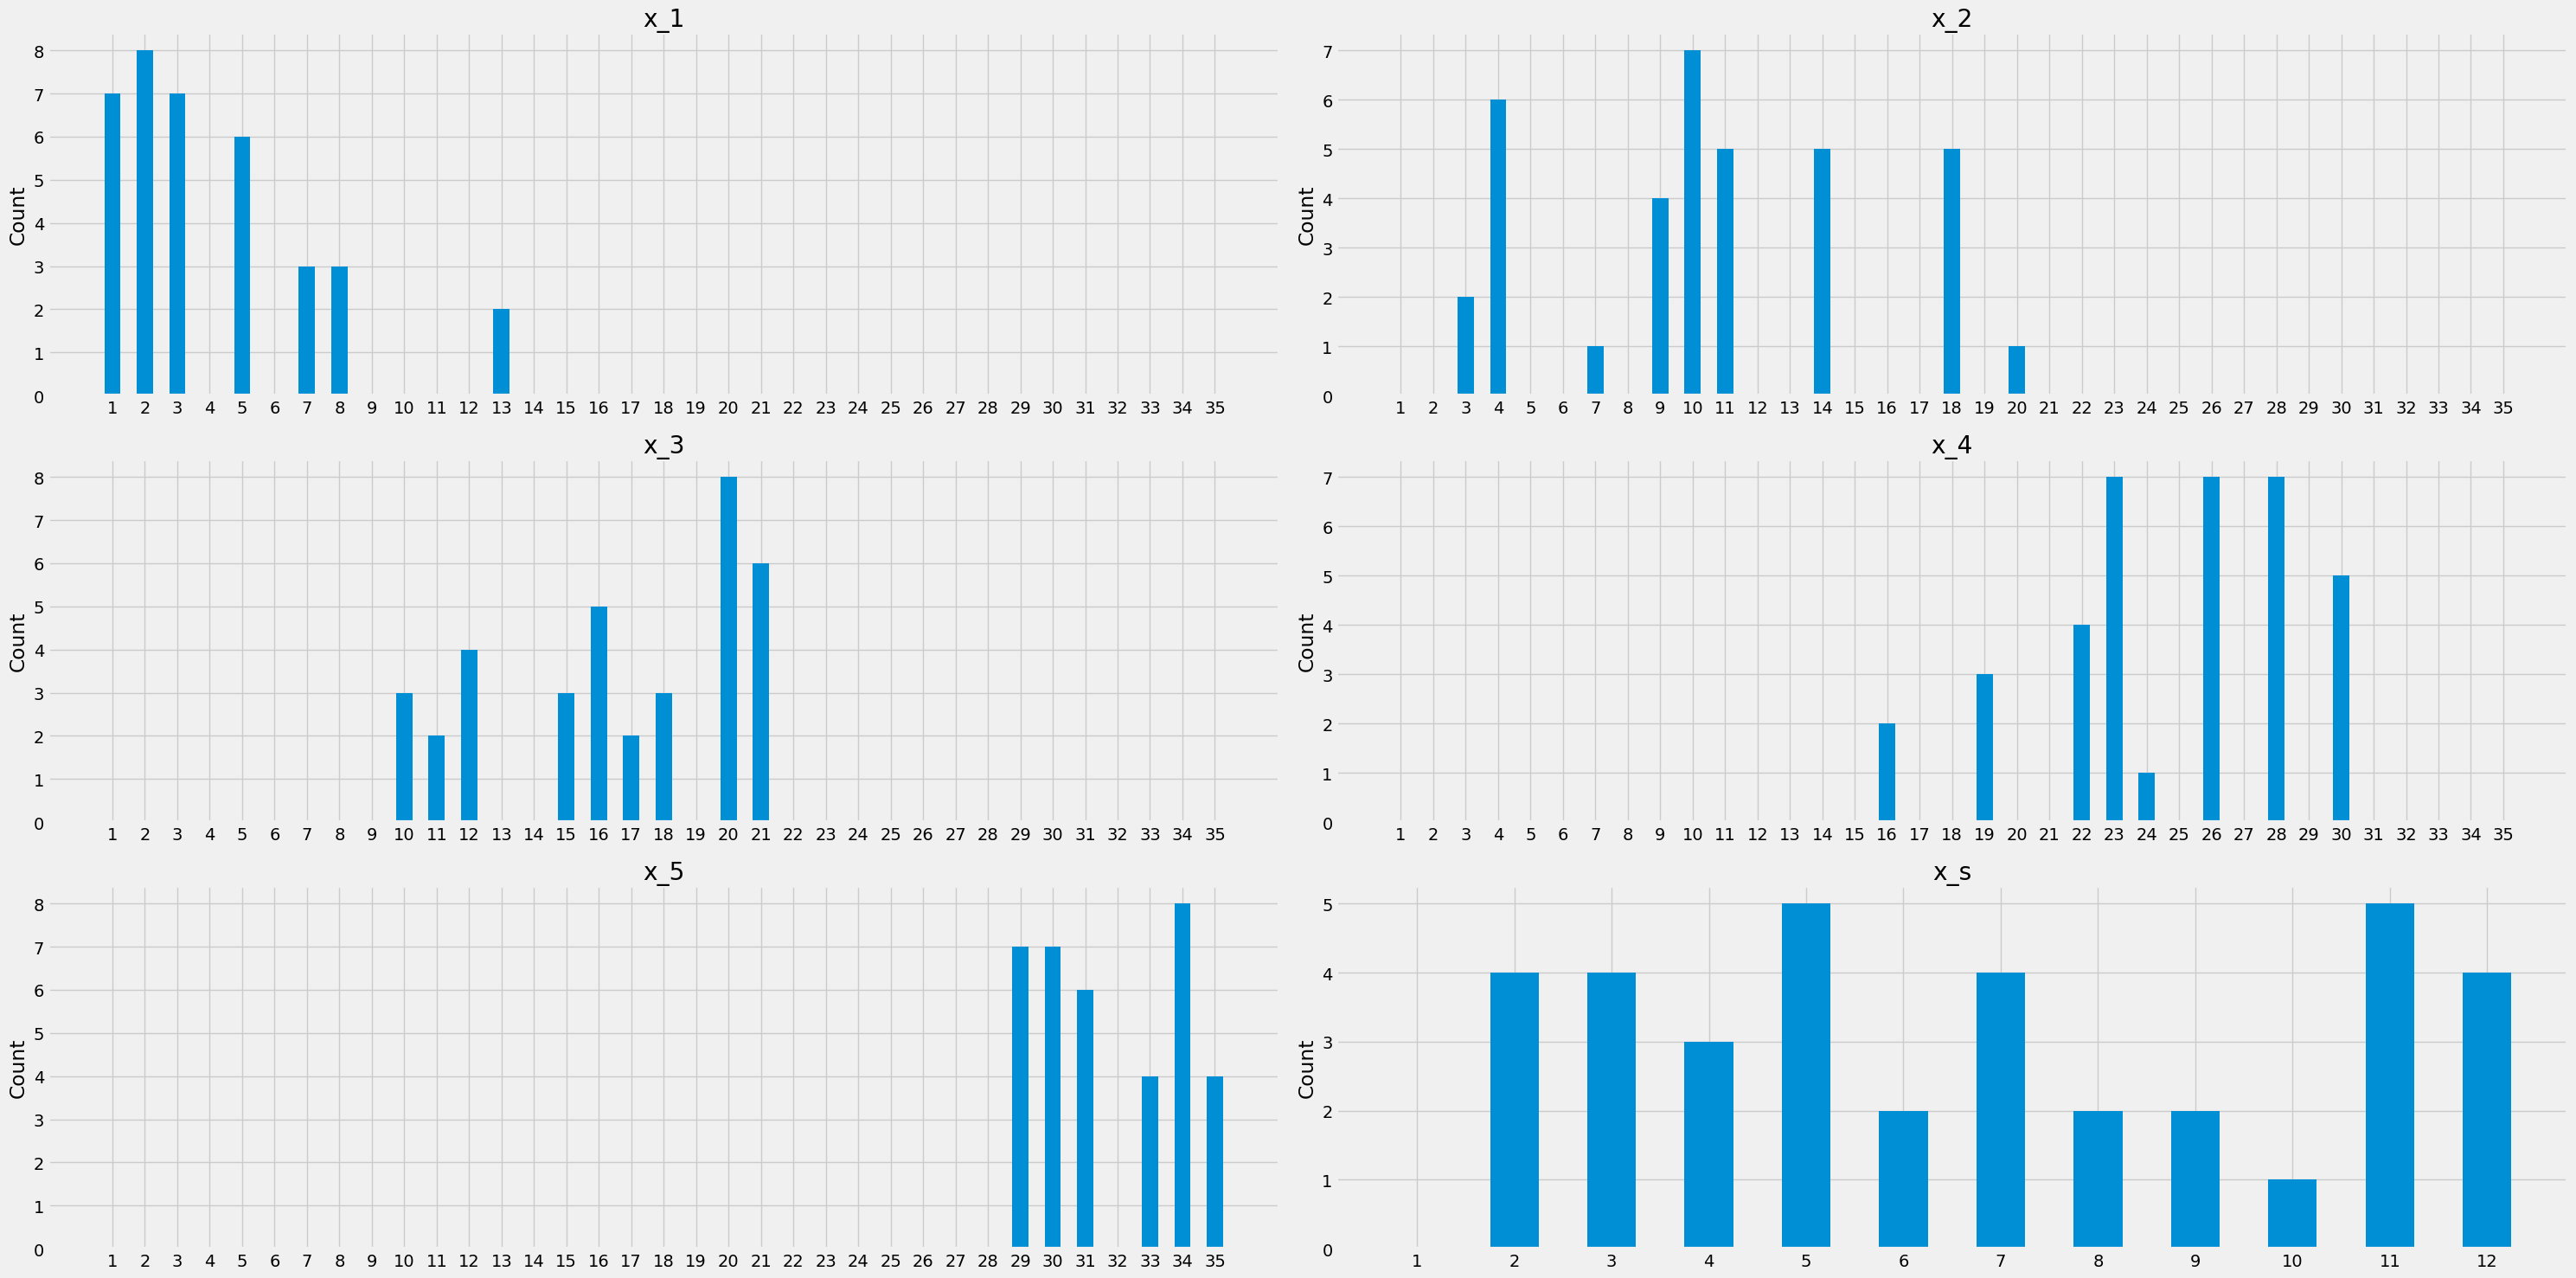

In [31]:
filter_5 = cleaned_df[
    cleaned_df["x_1"].isin([1, 2, 3, 5, 7, 8, 11, 13])
    & cleaned_df["x_2"].isin([3, 4, 7, 9, 10, 11, 14, 18, 20])
    & cleaned_df["x_3"].isin([16, 17, 18, 10, 11, 12, 15, 20, 21])
    & cleaned_df["x_4"].isin([22, 23, 24, 16, 19, 18, 26, 28, 30])
    & cleaned_df["x_5"].isin([29, 30, 31, 33, 34, 35])
]

plot_histograms(filter_5, mode="count")

### Create permutation

In [32]:
def create_ordered_permutations(ranges_dict, xs_values):
    # Separate ordered columns
    ordered_keys = list(ranges_dict.keys())
    ordered_values = list(ranges_dict.values())

    # Step 1: Generate strictly increasing combinations
    ordered_permutations = [
        p
        for p in itertools.product(*ordered_values)
        if all(p[i] < p[i + 1] for i in range(len(p) - 1))
    ]

    # Step 2: Add independent x_s column (Cartesian product)
    final_rows = [(*p, xs) for p in ordered_permutations for xs in xs_values]

    return pd.DataFrame(final_rows, columns=ordered_keys + ["x_s"])

In [33]:
ranges = {
    "x_1": [1, 2, 3, 5, 7, 8, 11, 13],
    "x_2": [3, 4, 7, 9, 10, 11, 14, 18, 20],
    "x_3": [16, 17, 18, 10, 11, 12, 15, 20, 21],
    "x_4": [22, 23, 24, 16, 19, 18, 26, 28, 30],
    "x_5": [29, 30, 31, 33, 34, 35],
}


xs = [2, 3, 5, 7, 11, 12]

In [34]:
output_df = create_ordered_permutations(ranges, xs)
output_df

,x_1,x_2,x_3,x_4,x_5,x_s
0,1,3,16,22,29,2
1,1,3,16,22,29,3
2,1,3,16,22,29,5
3,1,3,16,22,29,7
4,1,3,16,22,29,11
...,...,...,...,...,...,...
77467,13,20,21,30,35,3
77468,13,20,21,30,35,5
77469,13,20,21,30,35,7
77470,13,20,21,30,35,11


In [35]:
output_df.to_csv(f"lotto_5_35_permutations_basic.csv", index=False, header=True)

In [36]:
df_a = cleaned_df.copy()
df_b = pd.DataFrame(output_df[["x_1", "x_2", "x_3", "x_4", "x_5", "x_s"]])

In [37]:
df_a

,date,hour,x_1,x_2,x_3,x_4,x_5,x_s,prize
0,20/02/26,21,1,9,18,28,33,7,6854822500
1,20/02/26,13,10,12,27,30,31,12,6727910000
2,19/02/26,21,9,21,23,25,29,3,6569592500
3,19/02/26,13,1,13,14,19,30,1,6438642500
4,18/02/26,21,9,23,27,29,33,1,6248570000
...,...,...,...,...,...,...,...,...,...
469,01/07/25,13,1,18,25,27,33,5,6676525000
470,30/06/25,21,1,12,13,27,28,7,6518352500
471,30/06/25,13,2,8,16,23,24,9,6315905000
472,29/06/25,21,6,12,14,18,25,8,6231295000


In [38]:
df_b

,x_1,x_2,x_3,x_4,x_5,x_s
0,1,3,16,22,29,2
1,1,3,16,22,29,3
2,1,3,16,22,29,5
3,1,3,16,22,29,7
4,1,3,16,22,29,11
...,...,...,...,...,...,...
77467,13,20,21,30,35,3
77468,13,20,21,30,35,5
77469,13,20,21,30,35,7
77470,13,20,21,30,35,11


In [39]:
common_rows = pd.merge(df_a, df_b)

common_rows

,date,hour,x_1,x_2,x_3,x_4,x_5,x_s,prize
0,20/02/26,21,1,9,18,28,33,7,6854822500
1,07/02/26,21,3,14,17,19,35,3,7683222500
2,03/02/26,21,5,10,11,28,29,5,6530512500
3,23/01/26,21,5,7,10,28,29,2,7931132500
4,16/01/26,13,1,3,10,26,34,3,6208430000
5,03/01/26,13,7,11,12,22,30,5,7302845000
6,11/12/25,21,3,10,16,23,29,11,9035090000
7,08/12/25,13,2,3,16,23,31,12,7980512500
8,05/12/25,13,13,18,20,28,30,3,7495930000
9,27/11/25,21,1,10,16,30,34,7,6235762500
